In [4]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

root_dir = Path("yelp_dataset") # Change w.r.t your own directory

In [5]:
! pwd

/Users/mingyuanma/Desktop/yelp_ac209a


### Data Description of Yelp Business Dataset 

#### Data Loading  

We download the data from [the official webset](https://www.yelp.com/dataset/download) through simple verification.

The original file is in JSON format. While loading data, we tried using the built-in pandas `read_json` method, but failed in the first place. Eventually we ended up reading the JSON file line by line and constructing the DataFrame from scratch. 

#### Data Description 
An official documentation is given by Yelp on [https://www.yelp.com/dataset/documentation/main](https://www.yelp.com/dataset/documentation/main)

The yelp dataset consists of five tables (and also one for photo data, though we're not gonna use it) in total, namely `business`, `review`,
`user`, `checkin`, `tip`. We start with looking into the `business` table, which describes attributes of merchants.

The raw DataFrame contains 14 columns, specifying: 
1. `business_id`: The unique ID of the business. Type: string
2. `name`: Name of the merchant. Type: string
3. `address`: Exact address of the merchant. Type: string
4. `city`: City where the merchant is located. Type: string
5. `state`: State where the merchant is located. Type: string 
6. `postal_code`: Postal code of the merchant. Type: string
7. `latitude`: Latitude of the location of merchant. Type: float64 
8. `longitude`: Longitude of the location of merchant. Type: float64
9. `stars`: Average rating of the merchant. Type: float64
10. `review_count`: Number of reviews the merchant has received so far. Type: int 
11. `is_open`: If the merchant still exists. Type: int
12. `attributes`: Attributes/ servies that the merchant provides. Type: dict
13. `categories`: Labels of the merchant. Type: string (with categories separated by commas)
14. `hours`: Opening hours of the merchant. Type: dict

There are 150346 merchants in total.

In [6]:
business_json = root_dir / "yelp_academic_dataset_business.json" # Change dataset name if necessary
data_file = open(business_json)

data = []
for line in data_file:
    data.append(json.loads(line))
checkin_df = pd.DataFrame(data)
data_file.close()

checkin_df.shape, checkin_df.dtypes

((150346, 14),
 business_id      object
 name             object
 address          object
 city             object
 state            object
 postal_code      object
 latitude        float64
 longitude       float64
 stars           float64
 review_count      int64
 is_open           int64
 attributes       object
 categories       object
 hours            object
 dtype: object)

In [7]:
checkin_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


#### Data Manipulation

The first thing we notice is how to break down and make use of the object-type columns (`attributes` and `categories`), since they are descriptive features that reflect how comfortable the dining experience is, and how good the merchant might be. We first check the possible values of the attributes and categories, and we found that there are **1311** possible categories and **39** possible attributes in total. Besides, a merchant tends to have more than one category type and one or more attributes. Thus, how to encode those data becomes an interesting topic.

In [8]:
# dive into `attributes` and `categories` of the merchants
cat_set = set()
attr_set = set()
for i, row in checkin_df.iterrows():
    cat = row['categories']
    attr = row['attributes']
    if cat:
        for c in cat.split(', '):
            cat_set.add(c)
    
    if attr:
        for k in attr.keys():
            attr_set.add(k)

In [9]:
print("Possible category: ", len(cat_set))
print("Possible attribute: ", len(attr_set))

Possible category:  1311
Possible attribute:  39


#### Checking potential imbalance

Another thing is, is the stars of the merchants really imbalanced? Judging from the histogram, we can see that though there is sort of imbalance among classes(the majority of merchants has star of 3.5-4.5), every class has sufficient samples to analyze. Therefore, we can resample the data to solve the imbalance issue

{'whiskers': [<matplotlib.lines.Line2D at 0x2a3aa8a50>,
 'caps': [<matplotlib.lines.Line2D at 0x2a3aaa450>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a3a6d250>],
 'medians': [<matplotlib.lines.Line2D at 0x2a3aabd10>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a3a9f850>],
 'means': []}

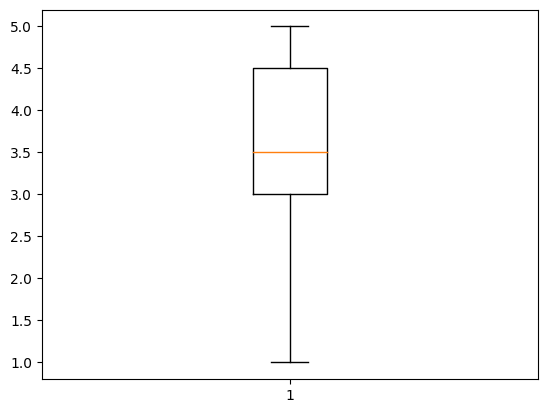

In [10]:
plt.boxplot(checkin_df["stars"])

Text(0.5, 1.0, 'Stars distribution')

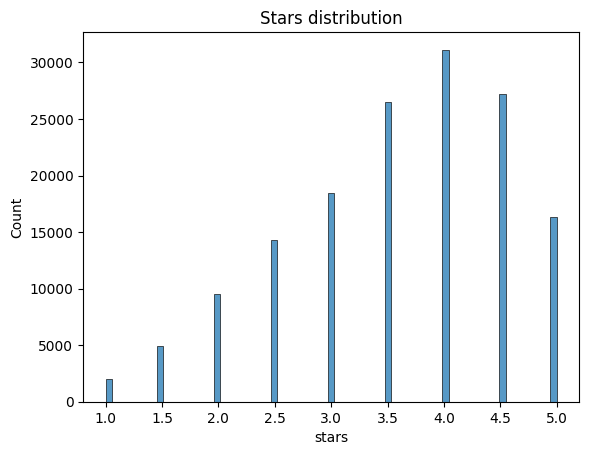

In [11]:
sns.histplot(data=checkin_df, x='stars').set_title('Stars distribution')

In [12]:
# Potential solution for imbalance issue.
cnt = checkin_df[checkin_df['stars']==1.0].shape[0]

new_df = pd.DataFrame()
for s in range(2, 11):
    star = s / 2
    sub_df = checkin_df[checkin_df['stars'] == star].sample(cnt)
    new_df = pd.concat([new_df, sub_df], axis=0)
new_df.shape

(17874, 14)

##### Differences in the scale of features

In our proposal, we do not rely too much on numeric data, so the scale of features does not matter too much.



#### Data Processing  
**1. Preliminary Missing Value Handling**  
By inspecting the dataset, we find that the following columns have missing values: 

| attributes | categories | hours    |
| :--------:   | :-------:    | :--------: |
| 13744      | 103        | 23223    |

`categories` is crutial for grouping merchants by their functionality, and there is no way we can interprete or evaluate out final result without knowing the purpose of the merchant. Furthermore, the number of missing values (103) is minimal compared to the whole dataset (> 150,000). Therefore, we will remove all merchants that are missing the `categories` labels.  
The number of missing values in the other two columns is not negligible. How we handle NULL `attribute` and `hours` will be stated later in the document.

**2. More In-depth Data Manipulation**  
The raw type of `attribute` column is a recursive dictionary. We decide to expand it into a group of one-hot vectors.  
We will first determine a comprehensive list of attributes by looping into each entry.We set up another dictionary (called `attribute_dict`) to keep track of the process by taking attribute names as keys and record all possible values.   
After constructing the dictionary, we would like to look at the possible values of each attribute. For those that only have "True/False", "yes/no" indicators, we will construct a new attribute column with only 0's and 1's (e.g.: 'BusinessAcceptsCreditCards', 'ByAppointmentOnly'). For those that have multiple levels or types, we will decide on a case-by-case manner (e.g.: for attributes that have internal ordering like 'NoiseLevel', we will provide an ordering scheme [0, 1, 2, 3]; for attributes that are not ordered like "Alcohol", we will separted each value as a one-hot vector.)

The raw type of `categories` column is a string separating category names with commas. We first create a list of categories for every merchant, and merge them together for a comprehensive list. 
One way to proceed is to creat a one-hot vector for each category. However, we noticed that there are more than 1,300 categories in total. Since we are not interested in all types of merchants, we may just select a subset of categories, and exclude all merchants that do not belong to these labels. 

Finally, the `hours` column is stored as a length-7 dictionary with days of the week as keys and a string representing operating hours as columns.  
We would like to first create 14 new columns storing the opening and closing time for each day of the week. We can add another column indicating if the merchant is missing the `hours` entry. 

**3. Further Missing Value Handling**  
After tidying and expanding data features, we go back to the `attribute` and `hours` column to handle their missing values. 

For NULL attributes, we can simply fill in all attribute-related columns with the "majority vote" (i.e., the mode of that column). 

For NULL hours, we can fill in the hour-related entries using mean imputation. 

In [13]:
# Inspect NULL values 
checkin_df.isna().sum(axis=0)

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64